In [1]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.preprocessing import OneHotEncoder
from neural_network_wrapper import NeuralNetworkWrapper
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
import optimizers

import json

In [2]:
data_simple_train_100 = pd.read_csv("./projekt1/classification/data.simple.train.100.csv")
data_simple_train_500 = pd.read_csv("./projekt1/classification/data.simple.train.500.csv")
data_simple_train_1000 = pd.read_csv("./projekt1/classification/data.simple.train.1000.csv")
data_simple_train_10000 = pd.read_csv("./projekt1/classification/data.simple.train.10000.csv")

data_simple_test_100 = pd.read_csv("./projekt1/classification/data.simple.test.100.csv")
data_simple_test_500 = pd.read_csv("./projekt1/classification/data.simple.test.500.csv")
data_simple_test_1000 = pd.read_csv("./projekt1/classification/data.simple.test.1000.csv")
data_simple_test_10000 = pd.read_csv("./projekt1/classification/data.simple.test.10000.csv")

In [3]:
def prepare_data_simple(train_data, test_data):
    
    X_train = np.array(train_data.loc[:, ['x', 'y']])
    y_train = train_data.cls
    y_train -= 1
    #one hot encoding
    y_ohc = np.zeros((y_train.size, int(np.max(y_train))+1))
    y_ohc[np.arange(y_train.size),y_train.astype(np.int)] = 1
    y_train = y_ohc
    
    X_test = np.array(test_data.loc[:, ['x', 'y']])
    y_test = test_data.cls
    y_test -= 1
    #one hot encoding
    y_ohc = np.zeros((y_test.size, int(np.max(y_test))+1))
    y_ohc[np.arange(y_test.size),y_test.astype(np.int)] = 1
    y_test = y_ohc
    
    
    # Are we supposed to use StandardScaler?
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    return {"X_train": X_train,
           "X_test": X_test,
           "y_train": y_train,
           "y_test": y_test}

In [4]:
data = [{"dataset name": "Data simple 100 obs",
        "data": prepare_data_simple(data_simple_train_100, data_simple_test_100)},
       {"dataset name": "Data simple 500 obs",
        "data": prepare_data_simple(data_simple_train_500, data_simple_test_500)},
       {"dataset name": "Data simple 1000 obs",
        "data": prepare_data_simple(data_simple_train_1000, data_simple_test_1000)},
       {"dataset name": "Data simple 10000 obs",
        "data": prepare_data_simple(data_simple_train_10000, data_simple_test_10000)}]

In [5]:
input_dim = 2
neuron_numbers = [4, 4, 2]
output_activation = ['sigmoid']
seed=42 #reproducibility
num_epochs=6
loss_function = 'logistic_loss'
learning_rate = 0.1

# Things we would like to test
activation_functions = ['relu', 'leaky_relu']
batch_size = 64 #[2*(i+1) for i in range(5)]
optimizer_beta = [0, 0.5, 0.9] # 0 means no inertia


experiment_dict = {
    "input_dim" : input_dim,
    "neuron_numbers" : neuron_numbers, # number of neurons in consecutive layers
    "activation_functions" : activation_functions,
    "loss_function" : loss_function,
    "batch_size" : batch_size,
    "num_epochs" : num_epochs,
    "seed" : seed,
    "output_activation" : output_activation,
    "learning_rate" : learning_rate
}

In [6]:
def perform_experiment(dataset,
                       d,
                       exp_objective,
                       exp_values,
                       num_reps):
    """
    """
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']

    d = d.copy()
    
    for k in exp_values.keys():
        d[k] = {}
        d[k]['test_accuracy'] = []
    
    for i in range(num_reps):
        #print(f"Experiment {i+1}/{num_reps}")
    
        # reproducibility issues
        random.seed(d['seed'] + i)
        np.random.seed(d['seed'] + i)
    
        # testing learning rate
        for k, v in exp_values.items():
            if exp_objective == 'lr':

                NN = NeuralNetworkWrapper(d['input_dim'],
                                      d['neuron_numbers'],
                                      ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                      d['loss_function'],
                                      v,
                                      optimizers.Optimizer(),
                                      d['batch_size'])
            
            elif exp_objective == 'activation_function':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          v * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.Optimizer(),
                                          d['batch_size'])
            
            elif exp_objective == 'inertia':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.GDwithMomentum(v),
                                          d['batch_size'])
            
            elif exp_objective == 'batch_size':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.Optimizer(),
                                          v)
            
                
            NN.train(X_train,
                     y_train,
                     d['num_epochs'],
                     validation_split = 0,
                     test_accuracy=(X_test, y_test),
                     verbosity=False)
                
            d[k]['test_accuracy'].append(NN.test_accuracy)

    for k in exp_values.keys():
        # aggregating results
        d[k]['test_accuracy_mean'] = np.mean(np.array(d[k]['test_accuracy']).T, axis=1)
        d[k]['test_accuracy_std'] = np.std(np.array(d[k]['test_accuracy']).T, axis=1)

        d[k] = {"Accuracy": d[k]['test_accuracy_mean'],
               "Accuracy std": d[k]['test_accuracy_std'],
               "Best Accuracy": np.max(d[k]['test_accuracy_mean']),
               "Best Accuracy std": d[k]['test_accuracy_std'][np.argmax(d[k]['test_accuracy_mean'])]}

    return {k: d[k] for k in exp_values.keys()}


In [7]:
# # perform_experiment(data[0]['data'],
# #                    experiment_dict,
# #                    'lr',
# #                    {'lr=0.1' : 0.001,
# #                    'lr=0.2' : 0.002},
# #                   10)
perform_experiment(data[0]['data'],
                   experiment_dict,
                   'activation_function',
                   {'relu' : ['relu'],
                   'leaky relu' : ['leaky_relu']},
                  3)


Final loss: 1.217
Final loss: 0.602
Final loss: 0.590
Final loss: 1.078
Final loss: 1.541
Final loss: 0.686


{'relu': {'Accuracy': array([0.57      , 0.59      , 0.64      , 0.69666667, 0.71666667,
         0.72333333]),
  'Accuracy std': array([0.10198039, 0.12961481, 0.12192894, 0.13474255, 0.14079141,
         0.14522014]),
  'Best Accuracy': 0.7233333333333333,
  'Best Accuracy std': 0.14522013940527978},
 'leaky relu': {'Accuracy': array([0.69      , 0.79      , 0.81666667, 0.83      , 0.83666667,
         0.85333333]),
  'Accuracy std': array([0.06683313, 0.04242641, 0.07318166, 0.07071068, 0.06649979,
         0.05792716]),
  'Best Accuracy': 0.8533333333333334,
  'Best Accuracy std': 0.057927157323275906}}

In [8]:
def experiments_pipeline(data,
                         experiment_dict,
                         num_reps=1,
                         save_to_file=False):
    """
    """
    d = experiment_dict.copy()
    output = {'lr':{},
             'activation_function':{},
             'inertia':{},
             'batch_size':{}}
    # Experiments for each dataset
    for dataset in data:
        print("------ Dataset name: {}".format(dataset['dataset name']))
        output['lr'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                     experiment_dict,
                                                     'lr',
                                                     {'lr=0.0001' : 0.0001,
                                                      'lr=0.001' : 0.001,
                                                      'lr=0.01' : 0.01,
                                                      'lr=0.1' : 0.1},
                                                     num_reps)
        output['activation_function'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'activation_function',
                                                        {'relu' : ['relu'],
                                                        'leaky relu' : ['leaky_relu']},
                                                        num_reps)
        
        output['inertia'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'inertia',
                                                        {'beta=0' : 0,
                                                        'beta=0.5' : 0.5,
                                                        'beta=0.9' : 0.9},
                                                        num_reps)
        
        output['batch_size'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'inertia',
                                                        {'bs=2' : 2,
                                                        'bs=8' : 8,
                                                        'bs=16' : 16,
                                                        'bs=64' : 64},
                                                        num_reps)
        
        
        
    return output

In [9]:
ans = experiments_pipeline(data, experiment_dict, num_reps=20)

------ Dataset name: Data simple 100 obs
Final loss: 1.693
Final loss: 2.092
Final loss: 1.579
Final loss: 1.264
Final loss: 3.395
Final loss: 1.391
Final loss: 1.409
Final loss: 1.321
Final loss: 2.993
Final loss: 1.448
Final loss: 2.116
Final loss: 1.123
Final loss: 1.637
Final loss: 1.774
Final loss: 1.690
Final loss: 0.716
Final loss: 2.456
Final loss: 2.273
Final loss: 1.556
Final loss: 0.455
Final loss: 1.586
Final loss: 1.917
Final loss: 1.458
Final loss: 0.508
Final loss: 4.760
Final loss: 1.583
Final loss: 1.340
Final loss: 1.197
Final loss: 2.823
Final loss: 3.561
Final loss: 2.638
Final loss: 0.478
Final loss: 2.146
Final loss: 2.688
Final loss: 1.206
Final loss: 1.395
Final loss: 1.551
Final loss: 1.563
Final loss: 2.849
Final loss: 1.221
Final loss: 2.197
Final loss: 2.311
Final loss: 1.473
Final loss: 0.961
Final loss: 1.145
Final loss: 1.610
Final loss: 2.309
Final loss: 1.394
Final loss: 1.321
Final loss: 1.166
Final loss: 1.895
Final loss: 0.695
Final loss: 1.709
Final

/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/loss_functions.py:5: RuntimeWarning: divide by zero encountered in log
  loss = (-1 / m) * (np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/loss_functions.py:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.divide(1 - y, 1 - y_hat) - np.divide(y, y_hat)
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/neural_network_core.py:38: RuntimeWarning: invalid value encountered in multiply
  dZ = dA * self.activation_function_derivative(Z)
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:21: RuntimeWarning: invalid value encountered in greater
  derivative[Z > 0] = 1
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:5: RuntimeWarning: overflow encountered in exp
  Z = 1 / (1 + np.exp(-Z))
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/loss_functions.py:5: RuntimeWarning: inva

Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
------ Dataset name: Data simple 500 obs
Final loss: 1.618
Final loss: 1.969
Final loss: 1.404
Final loss: 0.364
Final loss: 3.195
Final loss: 1.341
Final loss: 1.379
Final loss: 1.093

/usr/local/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Final loss: 3.202
Final loss: 1.448
Final loss: 1.947
Final loss: 0.502
Final loss: 1.637
Final loss: 1.606
Final loss: 1.387
Final loss: 0.190
Final loss: 2.320
Final loss: 2.308
Final loss: 1.322
Final loss: 0.189
Final loss: 1.645
Final loss: 1.663
Final loss: 1.059
Final loss: 0.166
Final loss: 4.484
Final loss: 1.378
Final loss: 1.256
Final loss: 0.530
Final loss: 2.779
Final loss: 2.970
Final loss: 1.852
Final loss: 0.259
Final loss: 2.051
Final loss: 2.754
Final loss: 1.087
Final loss: 1.017
Final loss: 1.651
Final loss: 1.585
Final loss: 1.434
Final loss: 0.331
Final loss: 1.922
Final loss: 1.944
Final loss: 1.284
Final loss: 0.472
Final loss: 1.168
Final loss: 1.605
Final loss: 1.340
Final loss: 1.357
Final loss: 1.338
Final loss: 1.174
Final loss: 0.943
Final loss: 0.315
Final loss: 1.684
Final loss: 2.100
Final loss: 1.281
Final loss: 0.630
Final loss: 1.785
Final loss: 1.847
Final loss: 1.197
Final loss: 0.496
Final loss: 3.258
Final loss: 1.627
Final loss: 1.472
Final loss

Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
------ Dataset name: Data simple 10000 obs
Final loss: 1.533
Final loss: 0.687
Final loss: 0.157
Final loss: nan
Final loss: 1.950
Final loss: 1.126
Final loss: 0.479
Final loss: nan
Final loss: 2.719
Final loss: 0.751
Final loss: 0.778
Final loss: nan
Final loss: 1.520
Final loss: 1.084
Final l

/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:26: RuntimeWarning: invalid value encountered in greater
  Z = ((Z > 0) * Z) + ((Z < 0) * Z * 0.01)
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:26: RuntimeWarning: invalid value encountered in less
  Z = ((Z > 0) * Z) + ((Z < 0) * Z * 0.01)
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:32: RuntimeWarning: invalid value encountered in greater
  derivative[Z > 0] = 1
/home/jakubkala/IAD/semestr-2/mgu/deep-learning-methods/activation_functions.py:33: RuntimeWarning: invalid value encountered in less
  derivative[Z < 0] = 0.01


Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: 0.047
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: 0.038
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: 0.033
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: 0.047
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: nan
Final loss: 0.03

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white")
#sns.despine(left=True, bottom=True)

plt.style.use('bmh')
#plt.style.use('seaborn-white')

# Available matplotlib styles:
# ['seaborn-colorblind', 'fast', 'seaborn-deep', 'fivethirtyeight', 'seaborn',
#  'Solarize_Light2', 'seaborn-talk', 'seaborn-darkgrid', 'ggplot', 'seaborn-bright',
#  'seaborn-paper', 'seaborn-pastel', 'bmh', 'seaborn-dark', 'seaborn-notebook',
#  'tableau-colorblind10', 'seaborn-white', '_classic_test', 'seaborn-ticks',
#  'seaborn-poster', 'seaborn-muted', 'dark_background', 'grayscale',
#  'seaborn-dark-palette', 'seaborn-whitegrid', 'classic']

def visualize_experiment(d, title="", figsize=(21, 12)):
    
    fig, a = plt.subplots(2, 2)
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    dataset_names = list(d.keys())
    
    fig.suptitle(title, fontsize=30)
    
    counter = 0
    for i in range(2):
        for j in range(2):
            
            subplot_dict = d[dataset_names[counter]]
            
            a[i][j].title.set_text(f'Accuracy in {dataset_names[counter]}')
            a[i][j].set_ylim((0, 1))
            a[i][j].set_xticks(range(1, 1 + len(subplot_dict[list(subplot_dict.keys())[0]]['Accuracy'])))
            
            a[i][j].set_xlabel('Epoch')
            a[i][j].set_ylabel('Accuracy')
            
            for k, v in subplot_dict.items():
                a[i][j].errorbar([it+1 for it in range(len(v['Accuracy']))],
                                 v['Accuracy'],
                                 yerr=v['Accuracy std'],
                                 linestyle='--',
                                 marker='o',
                                 label=k)

                
                
                a[i][j].legend(loc="upper left")
            
            counter += 1
    
    plt.show()
    
    # Experiment report
    dataset_names = []
    x = {}
    for dataset_name, exp_results in d.items():
        dataset_names.append(dataset_name)

        for k, v in exp_results.items():
            try:
                x[k].append("{:.2f} +- {:.2f}".format(v['Best Accuracy'], v['Best Accuracy std']))
            except:
                x[k] = ["{:.2f} +- {:.2f}".format(v['Best Accuracy'], v['Best Accuracy std'])]

    y = pd.DataFrame(x)
    y.index = dataset_names
    y.transpose()
    
    return y

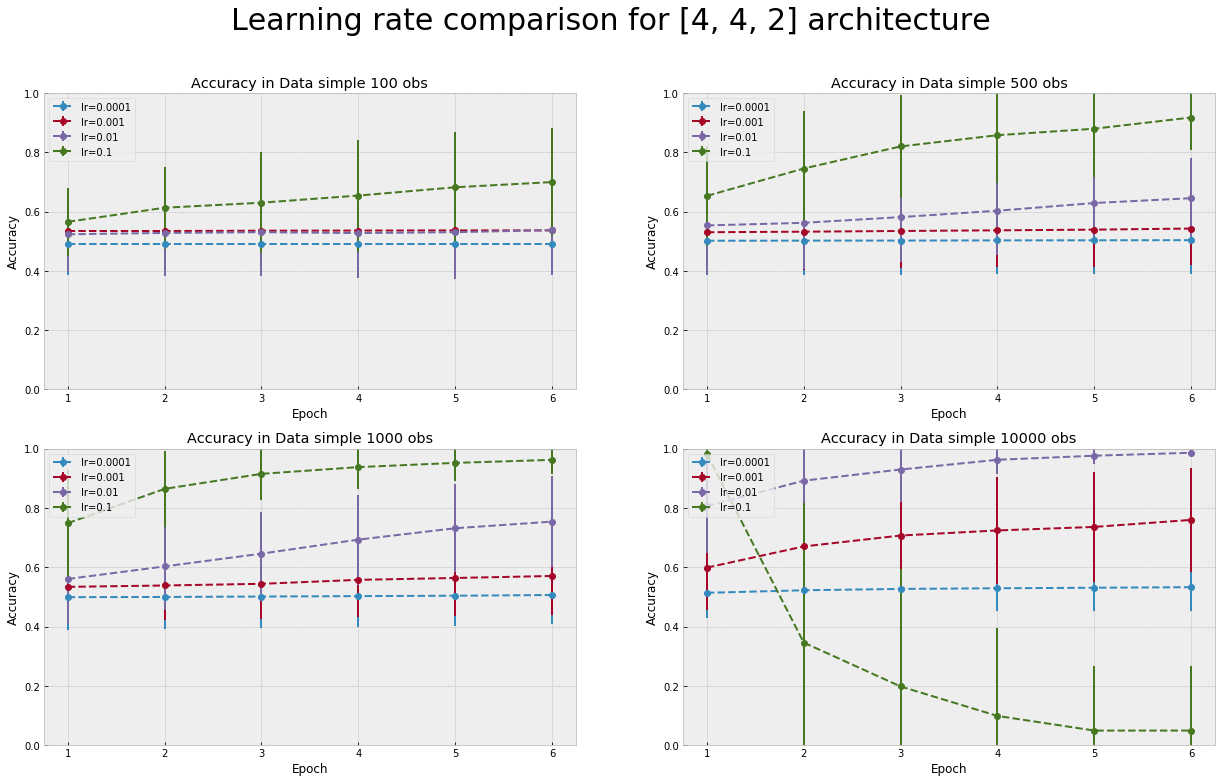

,lr=0.0001,lr=0.001,lr=0.01,lr=0.1
Data simple 100 obs,0.49 +- 0.10,0.54 +- 0.12,0.54 +- 0.15,0.70 +- 0.18
Data simple 500 obs,0.50 +- 0.11,0.54 +- 0.12,0.65 +- 0.14,0.92 +- 0.11
Data simple 1000 obs,0.51 +- 0.10,0.57 +- 0.13,0.75 +- 0.15,0.96 +- 0.05
Data simple 10000 obs,0.53 +- 0.08,0.76 +- 0.17,0.99 +- 0.01,0.98 +- 0.02


In [11]:
visualize_experiment(ans['lr'],
                     title='Learning rate comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

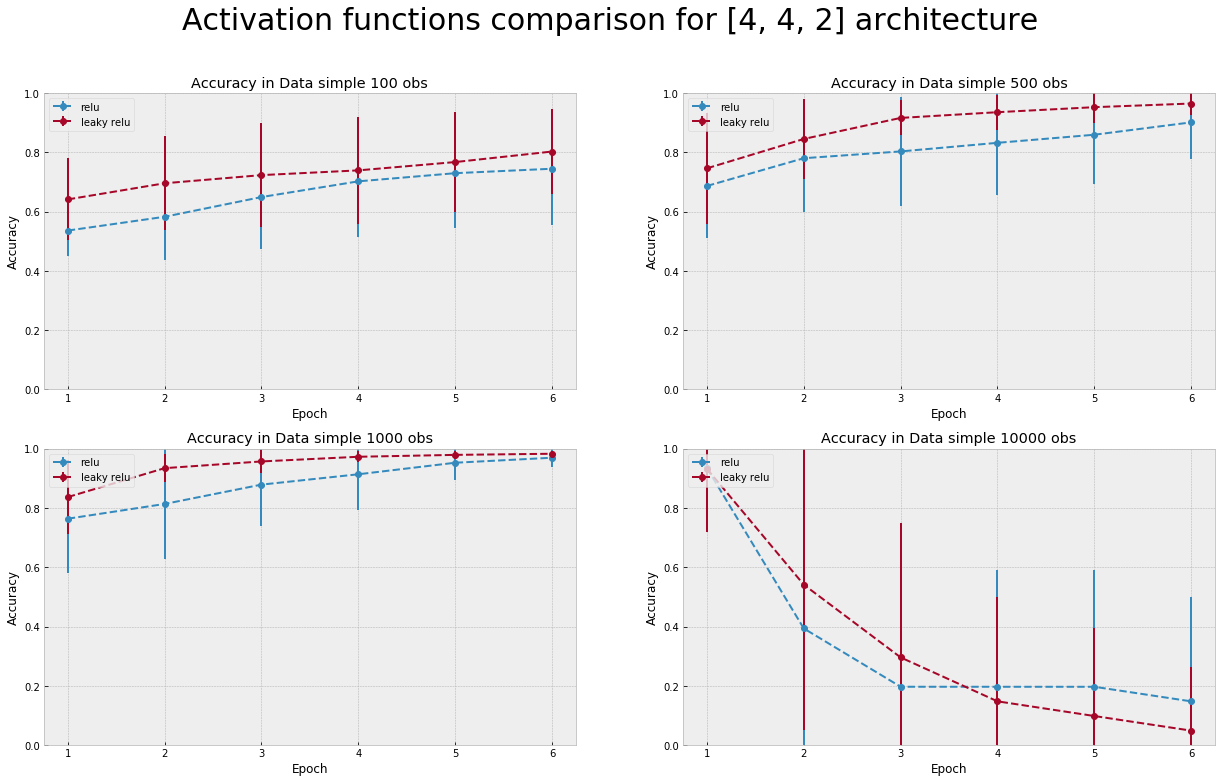

,relu,leaky relu
Data simple 100 obs,0.74 +- 0.19,0.80 +- 0.14
Data simple 500 obs,0.90 +- 0.12,0.96 +- 0.04
Data simple 1000 obs,0.97 +- 0.03,0.98 +- 0.01
Data simple 10000 obs,0.93 +- 0.21,0.93 +- 0.21


In [12]:
visualize_experiment(ans['activation_function'],
                     title='Activation functions comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

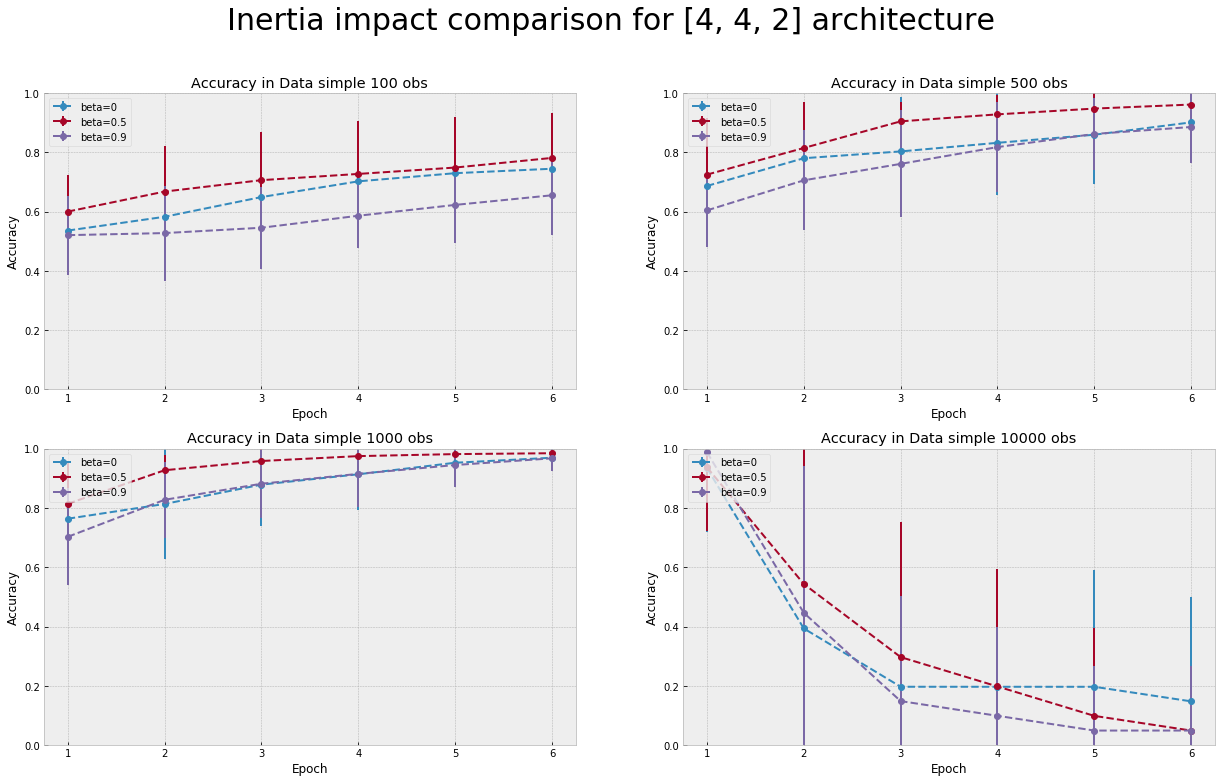

,beta=0,beta=0.5,beta=0.9
Data simple 100 obs,0.74 +- 0.19,0.78 +- 0.15,0.66 +- 0.14
Data simple 500 obs,0.90 +- 0.12,0.96 +- 0.04,0.89 +- 0.12
Data simple 1000 obs,0.97 +- 0.03,0.99 +- 0.01,0.97 +- 0.04
Data simple 10000 obs,0.93 +- 0.21,0.94 +- 0.22,0.99 +- 0.01


In [13]:
visualize_experiment(ans['inertia'],
                     title='Inertia impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

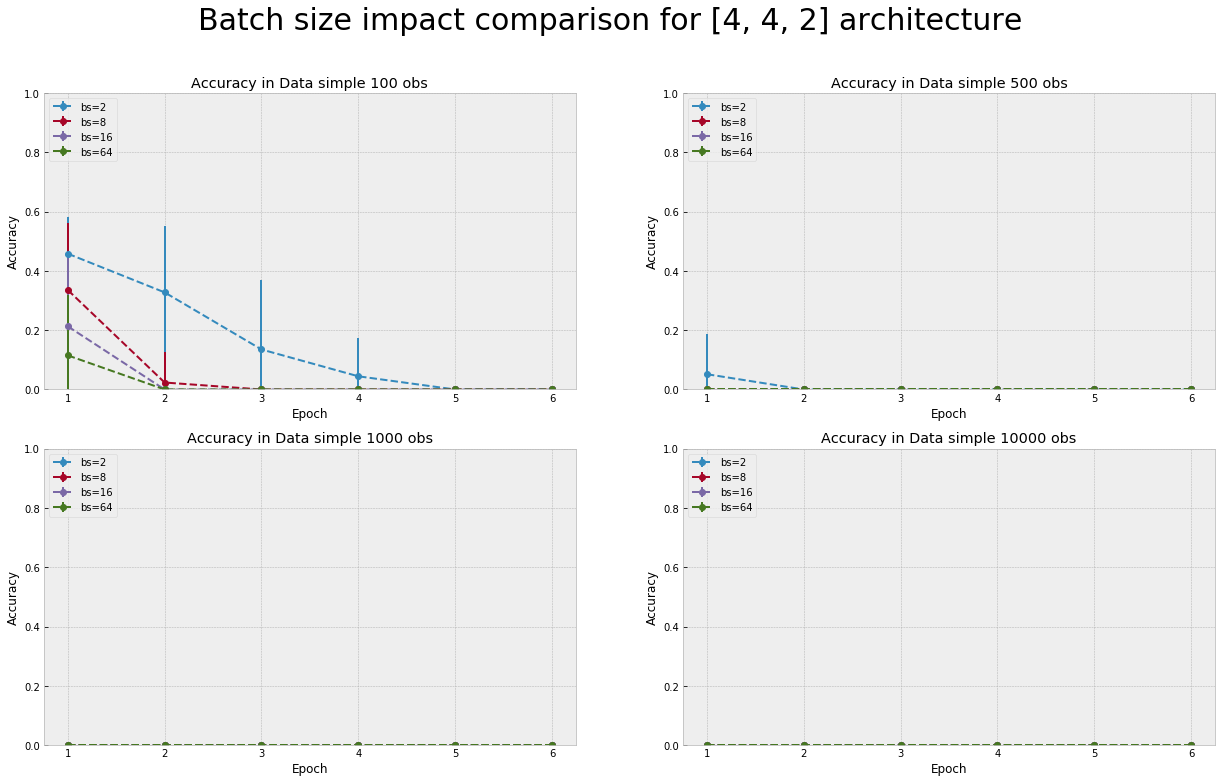

,bs=2,bs=8,bs=16,bs=64
Data simple 100 obs,0.46 +- 0.13,0.34 +- 0.22,0.21 +- 0.24,0.12 +- 0.20
Data simple 500 obs,0.05 +- 0.13,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00
Data simple 1000 obs,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00
Data simple 10000 obs,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00,0.00 +- 0.00


In [14]:
visualize_experiment(ans['batch_size'],
                     title='Batch size impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))